# Improvement for prediction in variable with less observations

Try improving the prediction in the variable with less observations using MTL models.

Firstly, Train an MTL model for streamflow and surface soil moisture in a period of 2005-2015. In this period, there is no observation data from SMAP. So, the model is trained only with streamflow data, but with the same structure as the MTL model trained with SMAP data.

Then, in the period of 2016-2018, the model is used to retrain with streamflow and surface soil moisture from SMAP. 

Finally, in 2018-2021, the model is used to predict streamflow and surface soil moisture. The result is compared with the prediction of the STL model trained only with SMAP data (train in 2015-2018, test in 2018-2021).

In [21]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

# Get the current directory of the notebook
notebook_dir = os.path.abspath("")
# Get the parent directory of the notebook directory
project_dir = os.path.dirname(notebook_dir)
# import the module using a relative path
sys.path.append(project_dir)
import definitions
from scripts.mtl_results_utils import (
    read_multi_single_exps_results,
    plot_mtl_results_map,
)
from hydromtl.utils import hydro_constant
from scripts.streamflow_utils import plot_ecdf_func
from hydromtl.visual.plot_stat import plot_scatter_with_11line


## Training

Some commands to train the model:

```bash
# STL Q
python run_task.py --exp expstlq201 --output_vars usgsFlow ssm --loss_weight 1.0 0.0 --train_period 2005-10-01 2015-10-01 --test_period 2015-10-01 2018-10-01 --ctx 0 --random 1234 --limit_part 1
# STL SSM
python run_task.py --exp expstlssm001 --output_vars usgsFlow ssm --loss_weight 0.0 1.0 --train_period 2015-10-01 2018-10-01 --test_period 2018-10-01 2021-10-01 --ctx 1 --random 1234 --limit_part 0
# MTL without STL-Q-pretrained
python run_task.py --exp expmtlqssm001 --output_vars usgsFlow ssm --loss_weight 0.5 0.5 --train_period 2015-10-01 2018-10-01 --test_period 2018-10-01 2021-10-01 --ctx 0 --random 1234
# MTL with STL-Q-pretrained; test_epoch is same as train_epoch
python run_task.py --exp expmtlqssm101 --output_vars usgsFlow ssm --loss_weight 0.5 0.5 --train_period 2015-10-01 2018-10-01 --test_period 2018-10-01 2021-10-01 --ctx 1 --random 1234 --weight_path /mnt/sdc/owen/code/HydroMTL/results/camels/expstlq201/model_Ep200.pth --train_epoch 100
```

After run all above commands, the results are saved in the folder `results/camels/`. The results are shown in the following figure.

## Results

In [11]:
exps_eval = ["expstlssm001", "expmtlqssm001", "expmtlqssm101"]
q_ssm_inds, _ = read_multi_single_exps_results(
    exps_eval,
    var_idx=1,
    ensemble=-1,
    var_names=[
        hydro_constant.streamflow.name,
        hydro_constant.surface_soil_moisture.name,
    ],
    var_units=["ft3/s", "mm/day"],
)


/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:391: RuntimeWarning: divide by zero encountered in double_scalars
  PBias[k] = np.sum(xx - yy) / np.sum(yy) * 100
/mnt/data/owen411/program/miniconda3/envs/MTL/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:399: RuntimeWarning: divide by zero encountered in double_scalars
  R2[k] = 1 - SSRes / SST
/mnt/sdc/owen/code/HydroMTL/hydromtl/utils/hydro_stat.py:400: RuntimeWarning: divide by zero encountered in double_scalars
  NSE[k] = 1 - SSRes / SST
/mnt/data/owen411/program/miniconda3/envs/MTL/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/data/owen411/program/miniconda3/envs/MTL/lib/python3.10/site-packages/numpy/lib/function_base

The STL ssm NSE is:

In [13]:
np.median(q_ssm_inds[0])

0.6487881967444535

The ssm NSE of MTL without pretrained model is:

In [14]:
np.median(q_ssm_inds[1])

0.6895572633182268

The ssm NSE of MTL with pretrained model is:

In [16]:
np.median(q_ssm_inds[2])

0.7039296915702933

After reading results, we can plot for the results.

## Plotss

Plot a Empirical Cumulative Distribution Function (ECDF) of NSE for above MTL models.

plot CDF


/mnt/sdc/owen/code/HydroMTL/scripts/streamflow_utils.py:380: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


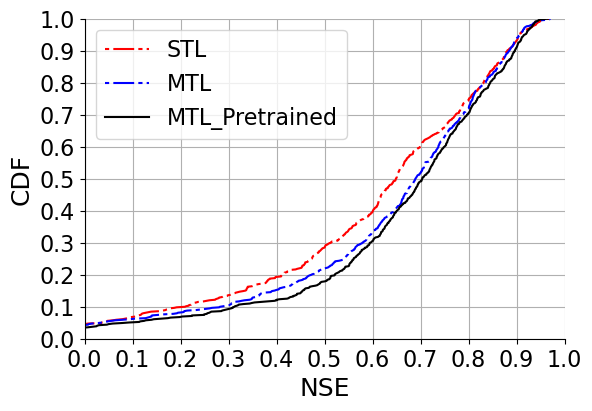

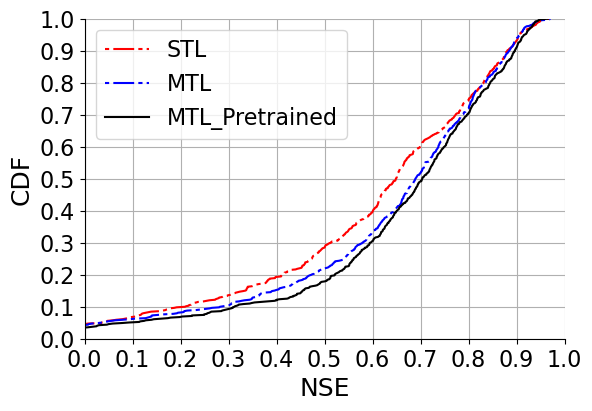

In [17]:
cases_exps_legends_together = [
    "STL",
    "MTL",
    "MTL_Pretrained",
]
figure_dir = os.path.join(definitions.RESULT_DIR, "figures")
plot_ecdf_func(
    q_ssm_inds[:-1],
    cases_exps_legends_together=cases_exps_legends_together,
    save_path=os.path.join(
        figure_dir,
        "stl_mtl_flow_ssm_w_wo_pretrained.png",
    ),
    dash_lines = [True, True, False],
    colors = ["red", "blue", "black"],
)


Plot a map for difference of the prediction of MTL with pretrained model and STL model.

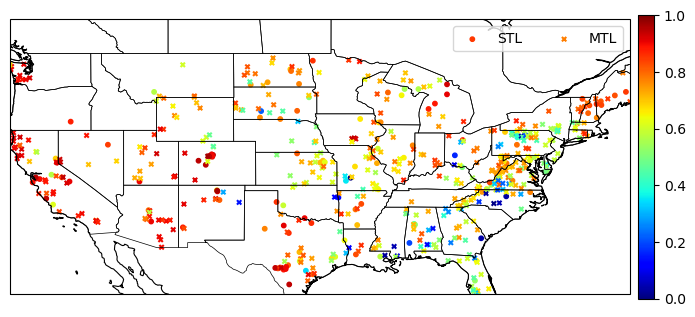

In [20]:
# plot map
plot_mtl_results_map(
    [q_ssm_inds[0], q_ssm_inds[2]],
    ["STL", "MTL_Pretrained"],
    ["o", "x"],
    os.path.join(
        figure_dir,
        "better_ssm_stl_mtl_cases_map.png",
    ),
)

Plot a scatter plot with 1:1 line for the prediction of MTL with pretrained model and STL model.

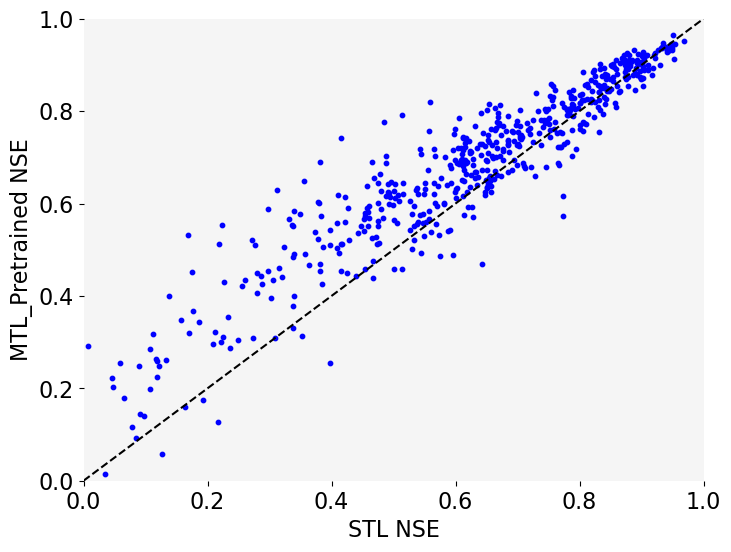

In [22]:
# plot scatter with a 1:1 line to compare single-task and multi-task models
plot_scatter_with_11line(
    q_ssm_inds[0],
    q_ssm_inds[2],  
    # xlabel="NSE single-task",
    # ylabel="NSE multi-task",
    xlabel="STL NSE",
    ylabel="MTL_Pretrained NSE",
)
plt.savefig(
    os.path.join(
        figure_dir,
        "mtl_stl_ssm_scatter_plot_with_11line.png",
    ),
    dpi=600,
    bbox_inches="tight",
)
